## Sampler of Terrestrial PACE Data Techniques 
Authors: Skye Caplan (NASA, SSAI) 

Last Updated: 02/04/2026

<div class="alert alert-info" role="alert">

An [Earthdata Login](edl) account is required to access data from the NASA Earthdata system, including NASA PACE data.

</div>

### Summary
This notebook is intended to be an overview of some useful tools for exploring PACE data with Python. We'll go over opening and visualizing Level 2 (L2) and Level 3 (L3) files, masking the data for any unwanted conditions, and how to calculate the difference in Normalized Burn Ratio (dNBR) to showcase the usefulness of PACE for forest remote senisng. We will be using powerful Python libraries such as ```xarray```, ```earthaccess```, ```rasterio```, and ```rioxarray``` to accomplish the learing objectives below. 

### Learning Objectives
1. Use ```earthaccess``` to search for and download L2 and L3 PACE data
2. Open and mask the data for clouds and water
3. Understand the differences between L2 and L3 data
4. Regrid L2 surface reflectance data and calculate useful variables from them
5. Visualize the different types of data used throughout the notebook
6. Export the data to GeoTIFF or NetCDF format

## Contents
1. [Setup](#1.-Setup)
2. [Time Series with L3 Data](#2.-Time-Series-with-Level-3-Data)
    - 2.1 Opening L3 Time Series Data
    - 2.2 Plotting L3 Time Series Data
3. [Normalized Burn Ratio with Level 2 Data](#3.-Normalized-Burn-Ratio-with-Level-2-Data)
    - 3.1 Opening, Subsetting, and Masking L2 Data
    - 3.2 Gridding Level 2 PACE Data
4. [Exporting to GeoTIFF or NetCDF](#4.-Exporting-to-GeoTIFF-or-NetCDF)

## 1. Setup 
Let's begin by importing the necessary packages. We'll be heavily featuring utilities of ```earthaccess```, ```xarray```, ```rasterio```, and ```rioxarray``` for exploring PACE data. If you're using the environment described in the [Getting Started](https://nasa.github.io/oceandata-notebooks/getting-started.html) section of the Help Hub, you should have all the correct version of each package installed. If you are choosing to use your own environment, please ensure you have the packages in the cell below installed and updated. At the very least, please ensure your environment has the most recent versions of ```rioxarray (>=0.19.0)``` and ```rasterio (>=1.4.3)```, as the functionality for managing L2 data is somewhat new. 

The ```auth = earthaccess.login()``` line in the following cell will authenticate our Earthdata Login credentials. Authentication is always needed to access data. We use the login method from the ```earthaccess``` package. This will create an authenticated session when we provide a valid Earthdata Login username and password. The ```earthaccess``` package will search for credentials defined by environmental variables or within a .netrc file saved in the home directory. If credentials are not found, an interactive prompt will allow you to input credentials.

In [1]:
import rasterio 
import cartopy
import earthaccess
import cf_xarray
import xarray as xr 
import numpy as np 
import cartopy.crs as ccrs
import rioxarray as rio 
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.enums import Resampling
from rasterio.crs import CRS
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Log in to Earthdata
auth = earthaccess.login()

Now that we are logged into ```earthaccess```, we get grab some files to start exploring PACE data.

## 2. Time Series with Level 3 Data

For this part of the tutorial, we're going to use Level 3 (L3) data to plot time series of vegetation indices at several different locations around the globe. To do this, we'll have to search through the entire PACE catalogue, which is pretty extensive given we are nearing the mission's 2nd full year in space at the time of writing. Thankfull,y we have the ```earthaccess``` package to do this task for us. Given a specific time period, product short name, and identifying details from the granule names, we can find every PACE L3 LANDVI file at our desired temporal and spatial resolution. 

LANDVI is the product suite name which contains all of the vegetation indices the PACE mission produces - details for the product can be found in the [Algorithm Theoretical Basis Document](https://www.earthdata.nasa.gov/apt/documents/landvi/v1.0). Other data products can be found at the [data products table](https://pace.oceansciences.org/data_table.htm).

Running the cell below will return a relatively large number of files. On top of that, L3 products are global maps, which means they contain a lot of data! Given the size of our desired dataset, we are going to download 8-day averaged files at 0.1 degree resolution, which is ~11 km at the equator. If this seems too large for the work you do, don't worry! PACE also produces L3 products at 4 km and 2 km spatial resolution. If you need finer than that, hold on until we work with Level 2 (L2) data in Section 3.

In [2]:
# Search for all available 8-day, 0.1 degree data
tspan = ("2025-01-01", "2026-02-03")

results_vi = earthaccess.search_data(
    short_name="PACE_OCI_L3M_LANDVI",
    temporal=tspan,
    granule_name="*.8D.*0p1deg*",  # Daily (DAY), 8-day (8D) or monthly (MO) | Resolution: 0p1deg, 4km, or 2km
)

print(f"Number of granules to download: {len(results_vi)}")

Number of granules to download: 38


You'll see above that for the time period from January 1, 2025 - February 3, 2026, we have 38 files (there will be more if you're returning to this notebook later in the year!). The next cell will download that data to a local directory called ```vi_data```. Each 0.1 degree resolution LANDVI file is ~52 MB.

<div class="alert alert-warning" role="alert">

Note that the total size of downloading 38 LANDVI files is ~2 GB

</div>

If you'd like to download less files, feel free to play around with the bounds in the ```tspan``` variable to search for a shorter timespan. 

In [3]:
paths_vi = earthaccess.download(results_vi, local_path="vi_data")

QUEUEING TASKS | :   0%|          | 0/38 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/38 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/38 [00:00<?, ?it/s]

### 2.1 Opening time series data

L3 data are produced on a consistent grid, which is a huge advantage for time series analyses. This means that you can stack these data and access the same locations across different times easily and within one ```xarray``` dataset. L3 data already comes with latitudes and longitudes assigned to each pixel as coordinates, but if we want to create a single dataset for this time series, having the date assigned to the respecitve arrays would be beneficial as well! 

Combined with ```xarray```'s ```open_mfdataset``` function, which opens multiple files as a single dataset, the ```time_from_attr()``` function grabs the time that the data was collected from the file metadata and sets that as a searchable coordinate, in addition to the latitudes and longitudes. For an 8-day averaged dataset, the "time of data collection" is the first day of that collection period. 

Using 8D data means that a lot of data gaps within the files, such as those due to persistent cloud cover in an area, are filled with at least one observation. However, gaps will still exist in some areas. To fill those gaps, we do a simple linear interpolation. Printing out the dataset, we can see we have a full dataset with 38 data points for every pixel on the globe. 

Finally, notice that we dropped several other VIs from the dataset - feel free to explore those as well!

In [4]:
def time_from_attr(ds):
    """
    Set the time attribute as a dataset variable in xarray
    Args:
        ds - a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds

# Open the dataset
vi_ds = xr.open_mfdataset(
    paths_vi,
    preprocess=time_from_attr,
    combine="nested",
    concat_dim="date",
)
vi_ds = vi_ds.drop_vars(["evi", "ndwi", "ndii", "cci", "ndsi", "palette"])

# Interpolate the data
try:
    vi_ds = vi_ds.interpolate_na(dim="date", method='linear', fill_value="extrapolate")
except:
    vi_ds = vi_ds.chunk({"date":-1})
    vi_ds = vi_ds.interpolate_na(dim="date", method='linear', fill_value="extrapolate")

vi_ds

<xarray.Dataset> Size: 5GB
Dimensions:  (lat: 1800, lon: 3600, date: 38)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date     (date) datetime64[ns] 304B 2025-01-01T00:07:38.161000 ... 2025-1...
Data variables:
    ndvi     (date, lat, lon) float32 985MB dask.array<chunksize=(38, 512, 1024), meta=np.ndarray>
    pri      (date, lat, lon) float32 985MB dask.array<chunksize=(38, 512, 1024), meta=np.ndarray>
    cire     (date, lat, lon) float32 985MB dask.array<chunksize=(38, 512, 1024), meta=np.ndarray>
    car      (date, lat, lon) float32 985MB dask.array<chunksize=(38, 512, 1024), meta=np.ndarray>
    mari     (date, lat, lon) float32 985MB dask.array<chunksize=(38, 512, 1024), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20250101_20250108.L3m.8D.LAND...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/LANDVI/3.1
    data_bins:                         1505159
    data_minimum:                      -83.5996
    data_maximum:                      24.639584

### 2.2 Plotting L3 Time Series Data

Now, we can plot some time series! In the next cell, there are 7 example points from forests from around the world. Sites were chosen based on proximity to ForestSAT 2026 participant locations. Feel free to play around with different locations and forest types (especially in the global south, which is not in the points below). Also, several sites are commented out for time during the workshop, but please uncomment them and see what those time series look like yourself.

In [5]:
# Set up points for plotting time series
sites = {"Switzerland, Temperate (46.8, 7.8)": (46.8, 7.8), 
         "Northern Quebec, Boreal (49.9, -72.3)": (49.9, -72.3), 
         "Florida, Subtropical (30.2, -84.8)": (30.2, -84.8),
         "West Virginia, Temperate (38.3, -80.3)":(38.3, -80.3),
         #"Utah, Temperate (37.6, -112.861)":(37.6, -112.861),
         #"Gutian Mountain, China, Subtropical (29.25, 118.13)": (29.25, 118.13),
         #"Alaskan Taiga, (63.8, -145.7)":(63.8, -145.7)
         }

Let's go through each site and plot their index values over the course of 2025. Just for visualization's sake, we use a Gaussian smoothing filter and divide each index by its maximum value. This method will allow us to preserve patterns in the data while making each index comparable on the same plot.

Notice how different the patterns are for each site location, even in forests that are broadly similar! We see that overall, the Chlorophyll Index Red Edge (Cire) corresponds well to NDVI as a relative "greenness" index, but the biochemistry of these locations is much more complex than can be seen with NDVI alone. Especially when considering the modified Anthocyanin Reflectance Index (mARI) and the Carotenoid Content Index (Car), pigment dynamics in these plots of forest show different responses throughout the year than might otherwise be expected.

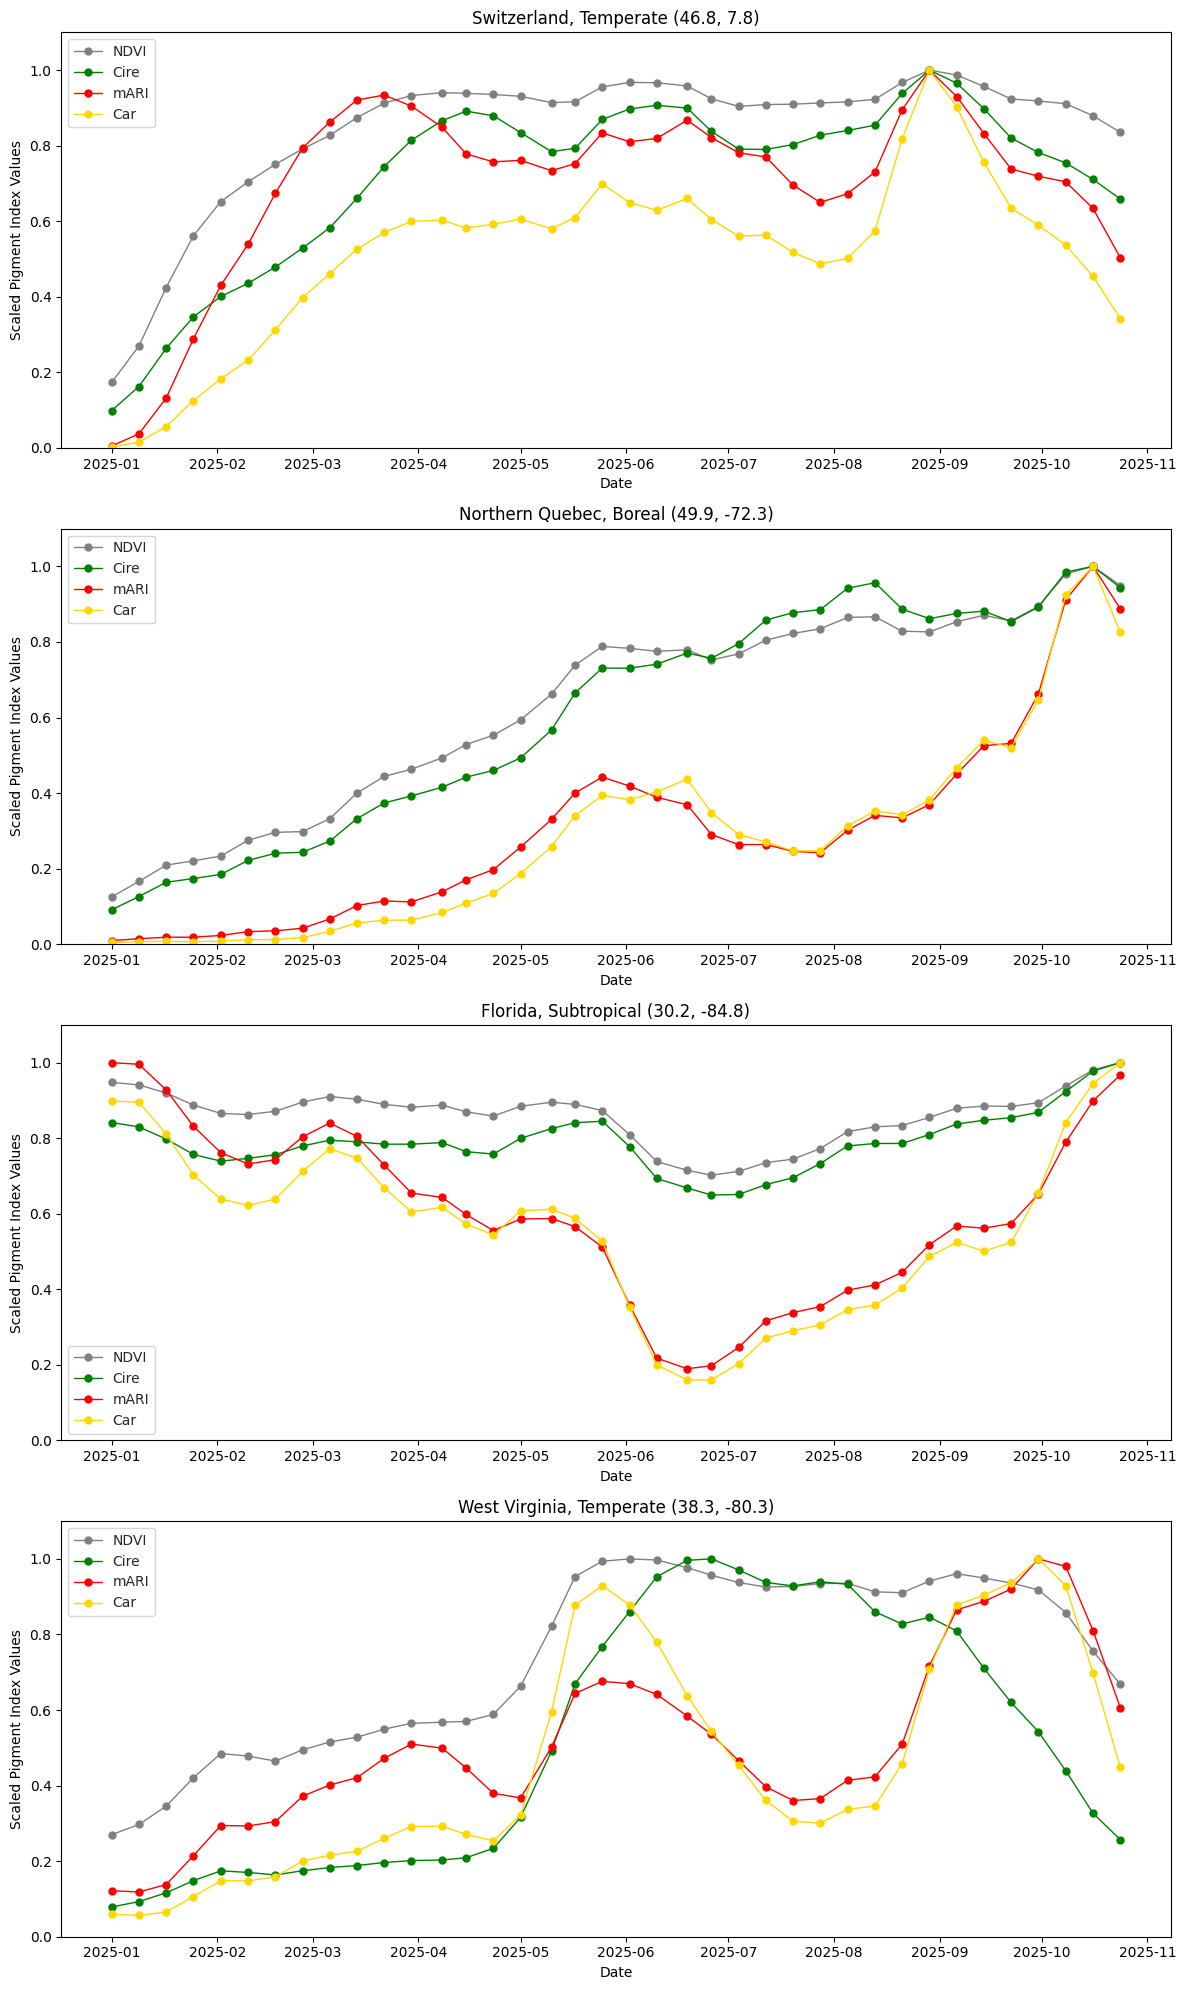

In [6]:
# Or make one for each site?
fig, ax = plt.subplots(len(sites), 1, figsize=(12,20))
linewidth = 1
markersize = 5
sns.set_style("white")
dates = vi_ds["date"]

i=0
for site in sites:
       pt = vi_ds.sel({"lat":sites[site][0], "lon":sites[site][1]}, method="nearest")

       ndvi = gaussian_filter1d(pt.ndvi.values, sigma=1)
       cire = gaussian_filter1d(pt.cire.values, sigma=1)
       mari = gaussian_filter1d(pt.mari.values, sigma=1)
       car = gaussian_filter1d(pt.car.values, sigma=1)
       
       ax[i].plot(dates, ndvi/np.nanmax(ndvi), "o-", color='grey', label="NDVI",
              linewidth=linewidth, markersize=markersize)
       ax[i].plot(dates, cire/np.nanmax(cire), "o-", color='g', label="Cire",
              linewidth=linewidth, markersize=markersize)
       ax[i].plot(dates, mari/np.nanmax(mari), "o-", color='r', label="mARI",
              linewidth=linewidth, markersize=markersize)
       ax[i].plot(dates, car/np.nanmax(car), "o-", color='gold', label="Car",
              linewidth=linewidth, markersize=markersize)
       ax[i].set_title(site)
       ax[i].set_ylabel("Scaled Pigment Index Values")
       ax[i].set_xlabel("Date")
       ax[i].set_ylim([0,1.1])
       ax[i].legend()
       i+=1
       
plt.tight_layout()
plt.show()

You may notice in the plots above that even though we searched data until the present day, the x-axis cuts off around November. Data from after that date until the present does exist! However, it exists in "Near Real Time" (NRT) form, and we only used the ```short_name``` corresponding to the Refined PACE data category. 

The difference is that that Refined data relies on ancillary input from other satellites and can take 1 - 2 months after original data collection to be produced. Near Real Time data is useful during that period, and will have ```_NRT``` attached to the file name. So, if you're looking for data that you know are there and are not seeing it, try looking for NRT data!

Now that we have a zoomed-out view of the globe, let's zoom in and see how we can work more site-specifically with L2 data. 

## 3. Normalized Burn Ratio with Level 2 Data

For this case study, we'll be investigating fires that occurred in August of 2025 in Spain and Portugal using the Normalized Burn Ratio (NBR). NBR is a multispectral vegetation index that PACE does not put out as a product, but can be calculated with its surface reflectance bands using the equatiob below:
$$NBR = \frac{NIR - SWIR}{NIR+SWIR}$$

The difference in NBR (dNBR) in time can be used to delineate burn scars in an area. dNBR is calculated as $dNBR = NBR_{prefire} - NBR_{postfire}$

L2 PACE OCI data is the finest resolution produced by the mission at 1.2 km at nadir, and so is useful for these more focused studies. We will use surface reflectance data from PACE's SFREFL data product suite. The suite contains surface reflectances at 122 bands from 350 - 2258 nm. More information can be found in the [ATBD](https://www.earthdata.nasa.gov/apt/documents/sfrefl/v1.0).

Unlike the time series example, we know we need to have specific, clear-sky granules for this analysis. Timestamps for each desired granule have already been chosen, and we'll loop through them to add them to a list of results that we then download to a local directory called ```sr_data```. Note that we are using averages of 2 pre- and 2 post-fire scenes to minimize the angular effects in the surface reflectance product.

<div class="alert alert-warning" role="alert">

The total size of downloading these 5 surface reflectance files is ~3.6 GB

</div>

In [7]:
time_stamps = ["*20250808T124711*","*20250726T131718*",
                "*20250916T123802*","*20250925T130313*", 
                "*20250925T125813*"]

results = []
for gran in time_stamps:
    res = earthaccess.search_data(
        short_name=["PACE_OCI_L2_SFREFL_NRT", "PACE_OCI_L2_SFREFL"],
        granule_name=gran,
    )
    results.append(res[0])
    
paths = earthaccess.download(results, local_path="sr_data")

QUEUEING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5 [00:00<?, ?it/s]

The download should locally take about 45 seconds. And now that we have the files, we can start exploring the data within them!

An important distinction between L2 and L3 data is that L2 data are in the instrument swath, i.e., are not gridded, so they have to be treated slightly differently. Practically, what this means is that while each L2 file has associated latitudes and longitudes for each pixel, if you overlaid two granules in the same area but from different times, the pixel centres would not line up. In order to calculate NBR, we will need to make sure our pixels align by putting on the same grid. 

### 3.1 Opening, subsetting, and masking L2 data

Before putting these data on the same grid we should open them and prepare the data inside. To do this, several functions have been defined below. Their purposes, input requirements, and outputs are described in the docstrings. 


In [12]:
def open_l2(filename):
    """ 
    Opens a L2 PACE OCI file and assign lat/lon (and wavelength if a 3D variable)
        as coordinates. Returns the entire geophysical_data groups in the 
        output dataset
    Args:
        filename - Path to input PACE OCI file
    Returns:
        ds - xarray dataset with lat/lon (and wavelength) as coords 
    """
    # Open file as datatree
    dt = xr.open_datatree(filename, decode_timedelta=False)
    # First try to open the dataset with wavelength_3d as a coordinate
    try:
        ds = xr.merge(
            (
            dt.ds,
            dt["geophysical_data"].to_dataset(),
            dt["sensor_band_parameters"].coords,
            dt["navigation_data"].ds.set_coords(("longitude", "latitude")).coords,
            )
        )
    except:
        # If that doesn't work, don't use sensor_band_params
        ds = xr.merge(
            (
            dt.ds,
            dt["geophysical_data"].to_dataset(),
            dt["navigation_data"].ds.set_coords(("longitude", "latitude")).coords,
            )
        )
    return ds

def subset(ds, extent):
    """
    Subset a L2 PACE file given an extent
    Args:
        ds - xarray dataset with lat/lon set as coordinates
        extent - list of boundaries in [w, s, e, n] configuration
    Returns:
        sub - subset of ds clipped to boundaries
    """
    sub = ds.where(
        (
          (ds["latitude"]  > extent[1])
        & (ds["latitude"]  < extent[3])
        & (ds["longitude"] > extent[0])
        & (ds["longitude"] < extent[2])
        ),
            drop=True,
        )
    return sub

def mask_ds(ds, flag="CLDICE", reverse=False):
    """
    Mask a PACE OCI dataset for L2 flags. Default is to mask for clouds only
    Args:
        ds - xarray dataset containing "l2_flags" variable
        flag - str or list of l2 flag to mask for (see https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/)
        reverse - boolean or list of booleans to keep only pixels with the desired flag. 
                  Default is False. E.g., set True to use "LAND" flag to mask water pixels. 
    Returns:
        Masked dataset
    """
    # Make sure flags are recognized by the package
    if ds["l2_flags"].cf.is_flag_variable:
        # If multiple flags, make sure reverse is also a list and then iterate
        if type(flag)==list:
            if type(reverse)!=list:
                reverse = [reverse for i in range(len(flag))]
            for f,r in zip(flag, reverse):
                if r == False:
                    ds = ds.where(~(ds["l2_flags"].cf == f))
                else:
                    ds = ds.where(ds["l2_flags"].cf == f)
                print(f"{f} mask applied")
            return ds
        else:
            if type(reverse)==list:
                reverse = reverse[0]
            if reverse == False:
                ds = ds.where(~(ds["l2_flags"].cf == flag))
            else:
                ds = ds.where((ds["l2_flags"].cf == flag))
            print(f"{flag} mask applied")
            return ds
    else:
        print("l2_flags not recognized as flag variable")
        return ds



Let's open our pre-fire granules using the ```open_l2()``` function:

In [13]:
prefire_1 = open_l2(paths[0])
prefire_2 = open_l2(paths[1])

If we plot one of the L2 granules we just opened, we'll see that the SFREFL suite contains surface reflectances for all pixels, including clouds, water, and area outside of our region of interest.

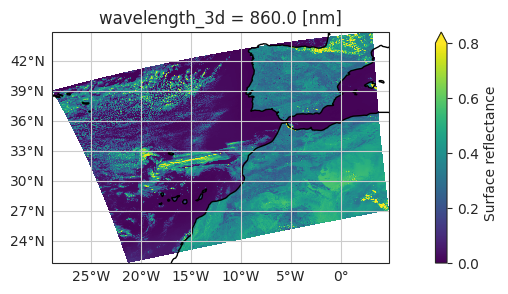

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
prefire_2.rhos.sel({"wavelength_3d":860}, method="nearest").plot(x="longitude", y="latitude", vmin=0, vmax=0.8)
plt.show()

For this analysis, we are only interested in the western part of the Iberian Peninsula, so we can use the ```subset()``` and ```mask_ds()``` functions to mask for clouds and water, and to subset to our desired region. The ```l2_flags``` variable in our ```prefire_1``` and ```prefire_2``` dataset are what allow us to mask the data for these conditions. A full list of the quality flags contained in ```l2_flags``` and their meanings can be found at [this link](https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/).

In addition to the area subsetting, we will also select only the bands we are interested in for the NBR analysis to decrease our data volume. For NIR, we will use 870 nm, and for the SWIR band, we will use 2131 nm.

In [15]:
# Set up a scene to subset the image to
scene = (-10,  39, -2, 43.9)

# Subset to necessary bands only for speed
prefire_1 = prefire_1.sel({"wavelength_3d":[870, 2131]}, method="nearest")
prefire_2 = prefire_2.sel({"wavelength_3d":[870, 2131]}, method="nearest")

# Subset and Mask 
prefire_1, prefire_2 = subset(prefire_1, scene), subset(prefire_2, scene)
prefire_1 = mask_ds(prefire_1, flag=["CLDICE", "LAND"], reverse=[False, True])
prefire_2 = mask_ds(prefire_2, flag=["CLDICE", "LAND"], reverse=[False, True])

CLDICE mask applied
LAND mask applied
CLDICE mask applied
LAND mask applied


We can again plot both datasets to ensure no clouds or water made it through, and to see the extent of our data.

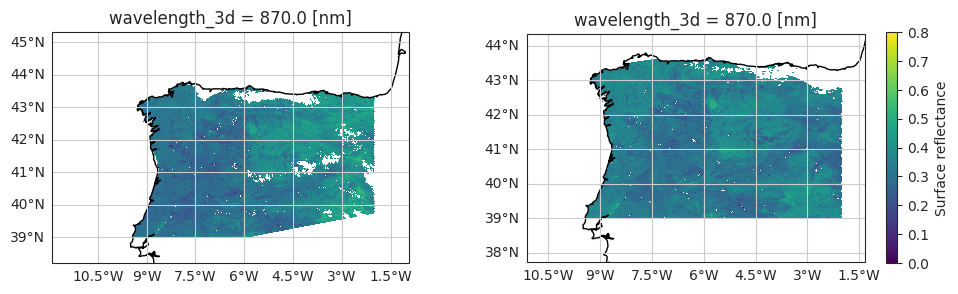

In [16]:
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), 
                       figsize=(12,3))
ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
prefire_1.rhos.sel({"wavelength_3d":870}, method="nearest").plot(x="longitude", 
                    y="latitude", vmin=0, vmax=0.8, ax=ax[0], add_colorbar=False)
prefire_2.rhos.sel({"wavelength_3d":870}, method="nearest").plot(x="longitude", 
                    y="latitude", vmin=0, vmax=0.8, ax=ax[1])
plt.show()

We have a subsetted surface reflectance dataset! But even in the plots above, you can see there are differences in the data coverage. We can solve this by merging the datasets, but to do that we have to put them on the same grid. 

### 3.2 Gridding Level 2 PACE Data

Earlier, we mentioned that L2 data are not gridded and therefore are not stackable immediately out of the box. The ```grid_data()``` function will put these datasets on matching grids so that they can be stacked and used for band ratios like NBR, or other time-dependent comparisons. The function defines a grid with the same parameters for both datasets, and applies that grid to each granule separately (so we don’t end up with a grid full of ```nans```). There are several things we’ll need to know in order to get our two granules on the same grid:

- The bounds of our desired grid
- Our desired resolution for the data
- The coordinate reference system (CRS) of our data, and the one we want our data projected into

All of these things will go into transforming the data. Since we prepared the masked rasters we’re using for this demonstration above, we have pretty much all of we need to create the grids. Below, the ```grid_data``` function is defined and takes in our datasets and desired resolution, and outputs gridded datasets.

In [17]:
def grid_data(src, resolution, dst_crs="epsg:4326", resampling=Resampling.nearest):
    """
    Grid a PACE OCI L2 dataset. Makes sure 3D variables are in (Z, Y, X) 
        dimension order, and all variables have spatial dims/crs assigned.
    Args:
        src - an xarray dataset or dataarray to reproject
        resolution - resolution of the output grid, in dst_crs units
        dst_crs - CRS of the output data
        resampling - resampling method (see rasterio.enums)
    Returns:
        dst - projected xr dataset
    """
    if (len(list(src.dims)) == 3) and (list(src.dims)[0] != "wavelength_3d"):
        src = src.transpose("wavelength_3d", ...)
    src = src.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    src = src.rio.write_crs("epsg:4326")

    # Calculating the default affine transform
    defaults = rasterio.warp.calculate_default_transform(
        src.rio.crs,
        dst_crs,
        src.rio.width,
        src.rio.height,
        left=np.nanmin(src.longitude.data),
        bottom=np.nanmin(src.latitude.data),
        right=np.nanmax(src.longitude.data),
        top=np.nanmax(src.latitude.data),
    )
    
    # Aligning that transform to our desired resolution
    transform, width, height = rasterio.warp.aligned_target(*defaults, resolution)
    
    dst = src.rio.reproject(
        dst_crs=dst_crs,
        shape=(height, width),
        transform=transform,
        src_geoloc_array=(
            src["longitude"],
            src["latitude"],
        ),
        nodata=np.nan,
        resample=resampling,
    )
    dst["x"] = dst["x"].round(9)
    dst["y"] = dst["y"].round(9)
    
    return dst.rename({"x":"longitude", "y":"latitude"})

Grid the data using the function above:

In [18]:
resolution = (0.015, 0.015)
prefire1_gridded = grid_data(prefire_1, resolution)
prefire2_gridded = grid_data(prefire_2, resolution)

The two datasets should now overlap! We can check this visually by zooming in on a plot and seeing if the pixel boundaries align...

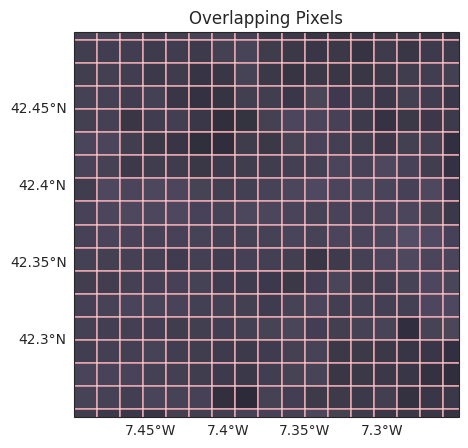

In [19]:
fig, ax = plt.subplots(figsize=(9, 5), sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25, alpha=0)
prefire1_gridded.rhos.sel({"wavelength_3d":860}, method="nearest").plot(cmap="Greys_r", vmin=0, vmax=1,
                                                         linewidth=0.05, edgecolors="red", add_colorbar=False)
prefire2_gridded.rhos.sel({"wavelength_3d":860}, method="nearest").plot(cmap="magma", vmin=0, vmax=3, 
                                                                   linewidth=0.05, edgecolors="white", 
                                                                   add_colorbar=False, alpha=0.4)
ax.set_extent((-7.5, -7.25, 42.25, 42.5))
plt.title("Overlapping Pixels")
plt.show()

...Which they do! The final step is to average these two days of data so that we have 1 prefire measurement for each surface reflectance wavelength

In [20]:
prefire_all = xr.combine_nested([prefire1_gridded, prefire2_gridded],concat_dim="time")
prefire_mean = prefire_all.mean("time")

Let's repeat this process with the post-fire data. Note that there is an extra file to complete coverage on the second day. 

In [21]:
# Open the files
postfire_1 = open_l2(paths[2])
postfire_2 = open_l2(paths[3]) 
postfire_2_2 = open_l2(paths[4])

In [22]:
# Grab only necessary bands only for speed
postfire_1 = postfire_1.sel({"wavelength_3d":[870, 2131]}, method="nearest")
postfire_2 = postfire_2.sel({"wavelength_3d":[870, 2131]}, method="nearest")
postfire_2_2 = postfire_2_2.sel({"wavelength_3d":[870, 2131]}, method="nearest")

# Subset and Mask 
postfire_1 = subset(postfire_1, scene)
postfire_2 = subset(postfire_2, scene)
postfire_2_2 = subset(postfire_2_2, scene)
postfire_1 = mask_ds(postfire_1, flag=["CLDICE", "LAND"], reverse=[False, True])
postfire_2 = mask_ds(postfire_2, flag=["CLDICE", "LAND"], reverse=[False, True])
postfire_2_2 = mask_ds(postfire_2_2, flag=["CLDICE", "LAND"], reverse=[False, True])

# Grid the data
postfire1_gridded = grid_data(postfire_1, resolution)
postfire2_gridded = grid_data(postfire_2, resolution)
postfire2_2_gridded = grid_data(postfire_2_2, resolution)

# Average all data days
postfire_all = xr.combine_nested([postfire1_gridded, 
                                  postfire2_gridded, 
                                  postfire2_2_gridded],
                                  concat_dim="time")
postfire_mean = postfire_all.mean("time")

CLDICE mask applied
LAND mask applied
CLDICE mask applied
LAND mask applied
CLDICE mask applied
LAND mask applied


We should now have a complete datasets of pre- and postfire observations of our area of interest. All that is left to do is to calculate NBR with the ```calc_nbr()``` function in the next cell.

In [23]:
def calc_nbr(nir, swir):
    """
    Calculates Normalized Burn Ratio given NIR and SWIR datasets
    Args:
        nir, swir - datasets of NIR and SWIR info
    Returns:
        nbr - NBR dataset
    """
    nbr = ((nir - swir) / (nir + swir))
    nbr = nbr.rename({"rhos":"nbr"})
    return nbr

In [24]:
prefire_nbr = calc_nbr(nir=prefire_mean.sel({"wavelength_3d":870}, method="nearest"), 
                       swir=prefire_mean.sel({"wavelength_3d":2131}, method="nearest"))
postfire_nbr = calc_nbr(nir=postfire_mean.sel({"wavelength_3d":870}, method="nearest"), 
                        swir=postfire_mean.sel({"wavelength_3d":2131}, method="nearest"))

To calculate dNBR and assess the burn scars and their extents in the area, subtract the postfire NBR from the prefire NBR as in the equation above.

In [25]:
dnbr = prefire_nbr - postfire_nbr
dnbr = dnbr.rename({"nbr":"dNBR"})

And plot the result:

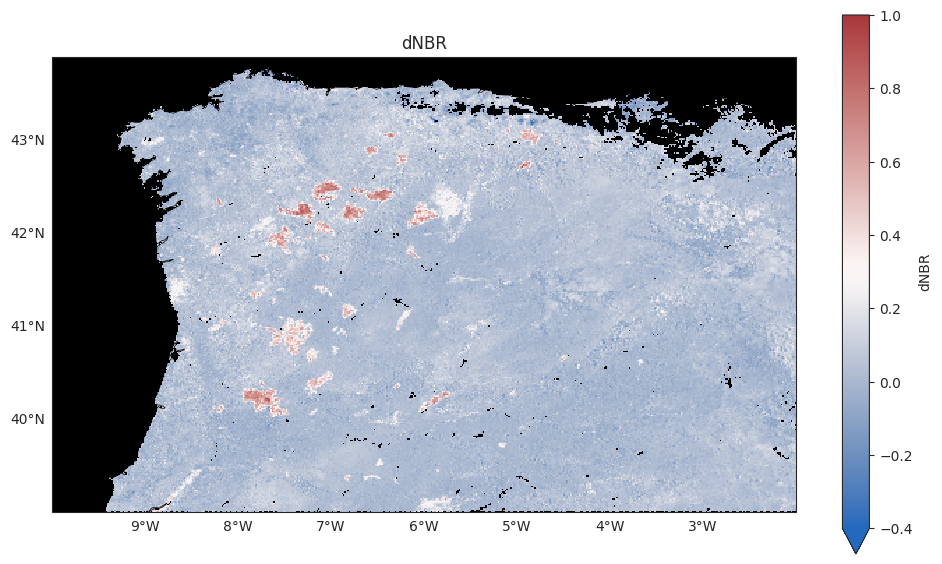

In [26]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.PlateCarree()})
dnbr.dNBR.plot(vmin=-0.4, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True))
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25, alpha=0)
ax.coastlines(linewidth=0.5)
ax.set_facecolor('k')
ax.set_extent([scene[0],scene[2],scene[1],scene[3]], crs=ccrs.PlateCarree())
ax.set_title("dNBR")
plt.show()

In the dNBR plot, values of 0.1 or higher are typically considered burned area, with burn severity increasing at higher values. We can see that these areas in Portugal and Spain had lot of wildfire activity in August of 2025.

## 4. Exporting to GeoTIFF or NetCDF

If you don't want to have to repeat these steps for your dNBR or other analyses, the best thing to do would be export your dataset to your favourite file format. The first one we will cover here is how to export a file as a Cloud Optimized GeoTIFF, or a COG, using GDAL's “COG” driver with applicable profile options.

We create our files by building a profile from the destination datasets (```dnbr```, in this case) and using the ```rio.to_raster()``` method. Each of the profile options is necessary for the format conversion, but can be changed to user preference as needed. For example, if you prefer a different nodata value, substitute the value you’d like to instead in the dictionary below.

In [64]:
# Could classify as well or export to file for plotting in GIS
dst_name = "ibr_fires_aug25_dnbr_whole.tif"
profile = {
    "driver": "COG",
    "width": dnbr["dNBR"].shape[1],
    "height": dnbr["dNBR"].shape[0],
    "count": 1,
    "crs": dnbr.rio.crs,
    "dtype": dnbr["dNBR"].dtype,
    "transform": dnbr.rio.transform(),
    "compress": "lzw",
    "nodata": np.nan,
    "interleave":"BAND",
    "tiled":"YES",
    "blockxsize": "512", "blockysize": "512",
}
dnbr["dNBR"].rio.to_raster(dst_name, **profile)

To export as a netCDF, all you need to do is use ```xarray```'s ```to_netcdf()``` function. Uncomment the lines in the cell below to begin the export:

In [ ]:
#dst_name = "ibr_fires_aug25_dnbr_whole.nc"
#dnbr.to_netcdf(dst_name)

If you are looking to convert L3 data to COG format, or would like to export the 3D surface reflectances themselves, there are some nuances to consider that we have not covered in this notebook. Please refer to the [Projecting & GeoTIFFs](https://nasa.github.io/oceandata-notebooks/notebooks/oci/oci_grid_match.html) notebook on the Help Hub for more information.

<div class="alert alert-info" role="alert">

Thank you for attending this ForestSAT pre-conference workshop! We hope this was a useful sampling of techniques that will get you started using PACE data for forestry in python. More tutorials using PACE data can be found on our [Help Hub](https://nasa.github.io/oceandata-notebooks/home.html)

</div>

